# RB notched

## Import

In [1]:
import os 
os.chdir('/CSNG/studekat/ripple_band_project/code')

In [2]:
from functions_analysis import *
import pandas as pd
import numpy as np
import yaml
import pickle
import neo
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt

## Parameters

In [3]:
with open("/CSNG/studekat/ripple_band_project/code/params_analysis.yml") as f:
    params = yaml.safe_load(f)

with open("/CSNG/studekat/ripple_band_project/code/params_plotting.yml") as f:
    params_plot = yaml.safe_load(f)

DATA_FOLDER = params['data_folder'] ### folder with all the preprocessed data
DATES = params['dates']

DF_FOLDER = '/CSNG/studekat/ripple_band_project/dataframes' ### here the resulting dataframes will be saved
MONKEY_LIST = ['L','N','F','A']

## Loading data

In [4]:
MONKEY = 'F'
ARRAY = 1
DATE = DATES[MONKEY]['RS'][1] # '20170809', the one with line noise spikes

In [5]:
spike_block = load_block(MONKEY,ARRAY,type_rec='RS',type_sig='spikes',
                                             date=DATE,data_folder=DATA_FOLDER)

In [6]:
RB_block = load_block(MONKEY,ARRAY,type_rec='RS',type_sig='RB',
                                             date=DATE,data_folder=DATA_FOLDER)
RB_arr = sig_block_to_arr(RB_block,'RB_filtered_zsc')

In [7]:
### NOTCH FILTER
### on each row of the input array

# Parameters for the notch filter
fs = 1000.0    # Sampling frequency (Hz)
f0 = 100.0     # Frequency to be removed (Hz)
Q = 30.0      # Quality factor

# Design notch filter
b, a = iirnotch(f0, Q, fs)

RB_notch = np.array([filtfilt(b,a,row) for row in RB_arr])

## Plotting example

In [8]:
spike_block.segments[0].spiketrains[-1]

SpikeTrain containing 40875 spikes with waveforms; units s; datatype float64 
name: 'Unit 8'
annotations: {'nix_name': 'neo.spiketrain.6ccaadf658c04f21aab734b47ea3bace',
  'num_spikes': np.float64(40875.0),
  'firing_rate': np.float64(65.5566857234138),
  'presence_ratio': np.float64(1.0),
  'snr': np.float64(3.0703137057817105),
  'isi_violations_ratio': np.float64(0.447076727233959),
  'isi_violations_count': np.float64(3594.0),
  'rp_contamination': np.float64(0.26600939518118305),
  'rp_violations': np.float64(1236.0),
  'sliding_rp_violation': np.float64(0.075),
  'amplitude_cutoff': np.float64(0.00023585004894760613),
  'amplitude_median': np.float64(-2.567171812057495),
  'amplitude_cv_median': 'None',
  'amplitude_cv_range': 'None',
  'sync_spike_2': np.float64(0.00836697247706422),
  'sync_spike_4': np.float64(0.0),
  'sync_spike_8': np.float64(0.0),
  'firing_range': np.float64(89.97),
  'drift_ptp': np.float64(0.0),
  'drift_std': np.float64(0.0),
  'drift_mad': np.float64(0

In [9]:
RB_arr.shape

(64, 623507)

In [10]:
RB_notch.shape

(64, 623507)

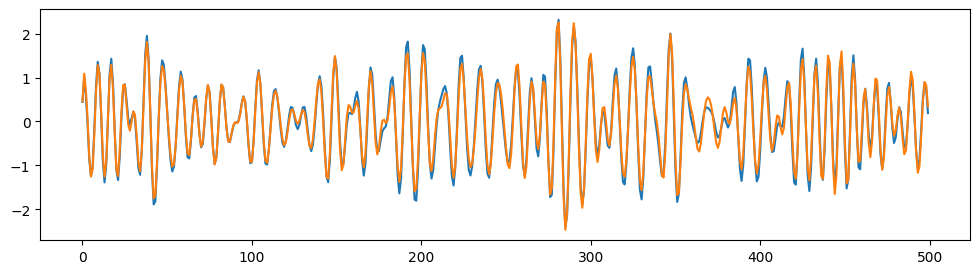

In [11]:
channel = 48 ### noisy 48
N = 0
WIDTH = 500

fig, ax = plt.subplots(1,1,sharex=True,sharey=True)
fig.set_figwidth(12)
fig.set_figheight(3)

ax.plot(RB_arr[channel,N*WIDTH:(N+1)*WIDTH])
ax.plot(RB_notch[channel,N*WIDTH:(N+1)*WIDTH])

plt.show()
plt.close()

In [14]:
def aux_RB_noise_prop(sig_vec,fs=1000):
    """
    100 Hz noise presence: 
    For a given vector of signal, compares the avg. PSD in the interval [98,102) and in [90,95). 
    If the power in the [98,102) interval is stonger, returns noise100 = True (there is 100 Hz noise present).

    For 120 Hz the same idea is used on intervals [118,122) and [110,115).

    Remark: In our analysis is used on spectra of RB signal, already filtered in [80,150].
    """
    frequencies, psd = welch(sig_vec, fs=fs, nperseg=fs*2)  # 2-second segments

    mask_100 = (frequencies>=98) & (frequencies<102)
    mask_before_100 = (frequencies>=90) & (frequencies<95)

    mask_120 = (frequencies>=118) & (frequencies<122)
    mask_before_120 = (frequencies>=110) & (frequencies<115)
    
    psd_around100 = np.mean(psd[mask100])
    psd_before100 = np.mean(psd[mask_before_100])
    
    psd_around120 = np.mean(psd[mask120])
    psd_before120 = np.mean(psd[mask_before_120])

    noise100 = psd_around100 > psd_before100
    noise120 = psd_around120 > psd_before120
    
    return noise100, noise120

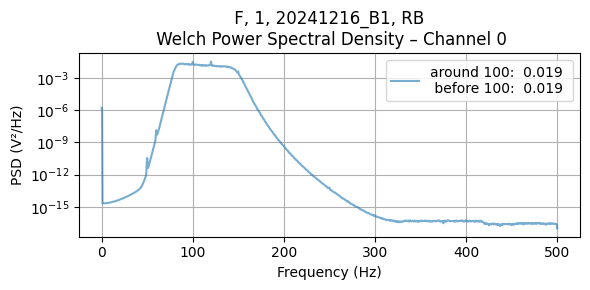

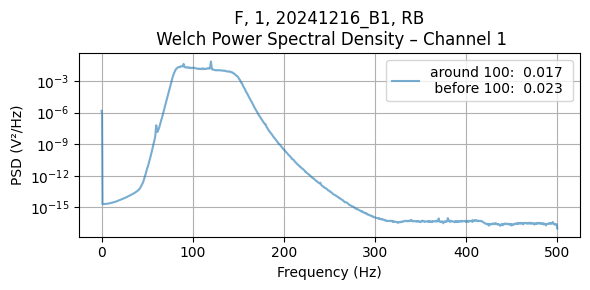

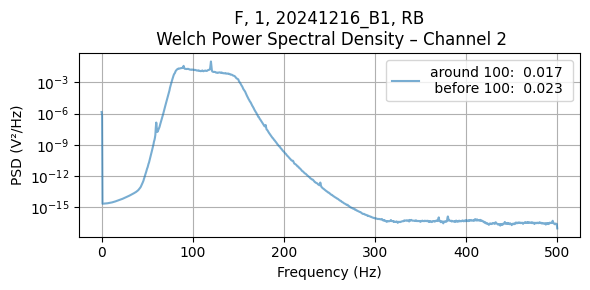

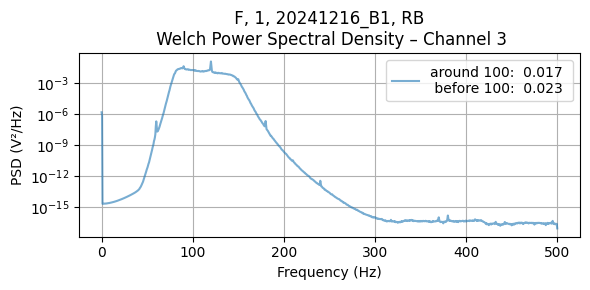

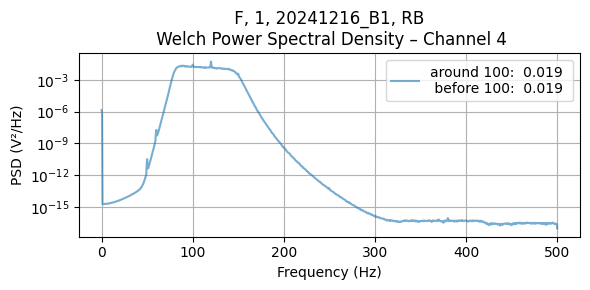

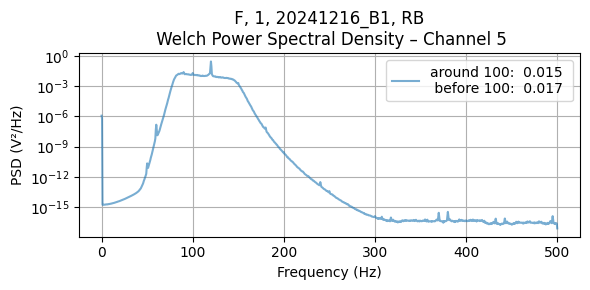

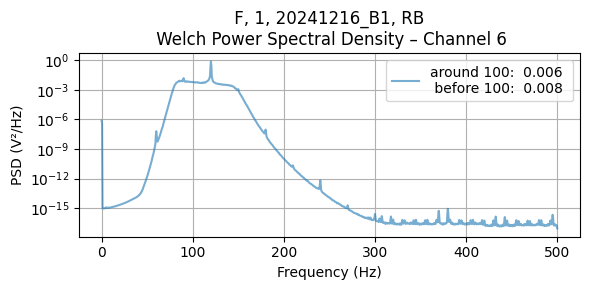

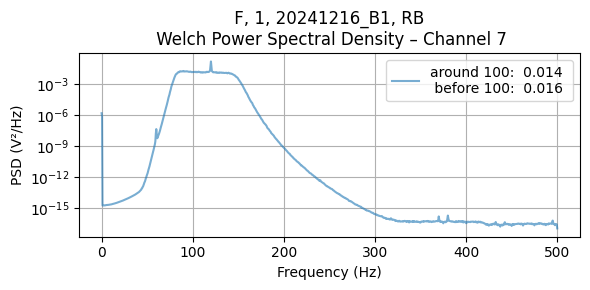

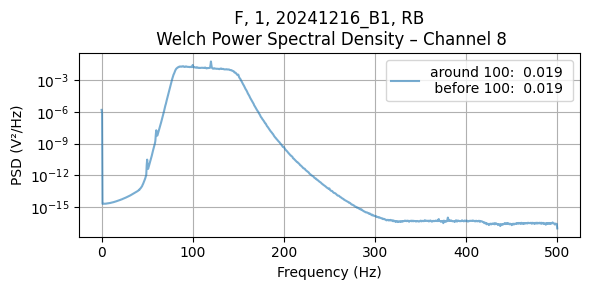

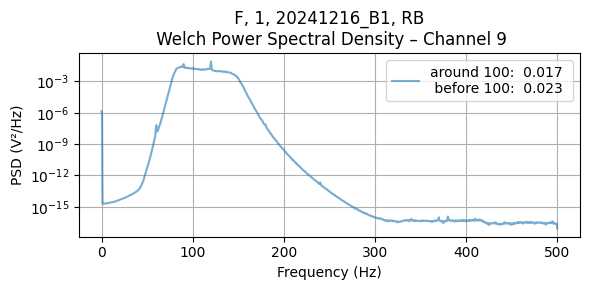

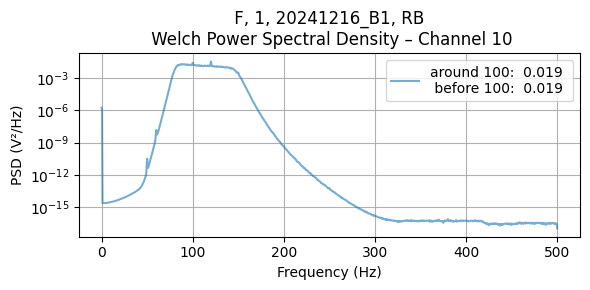

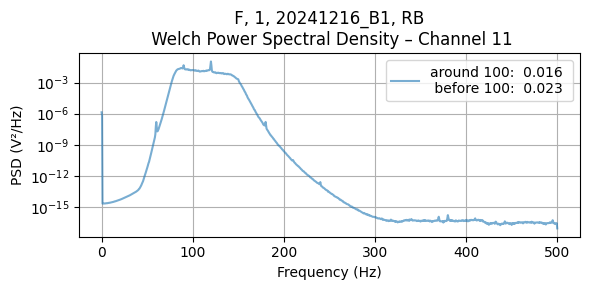

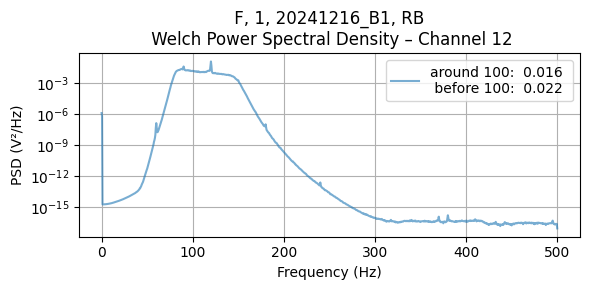

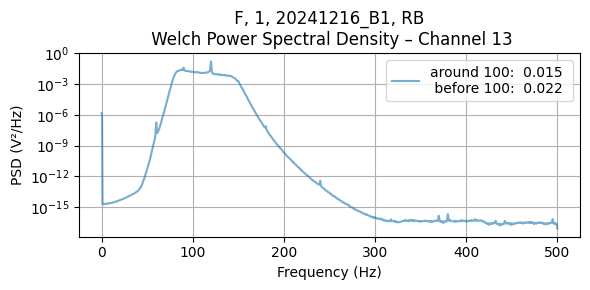

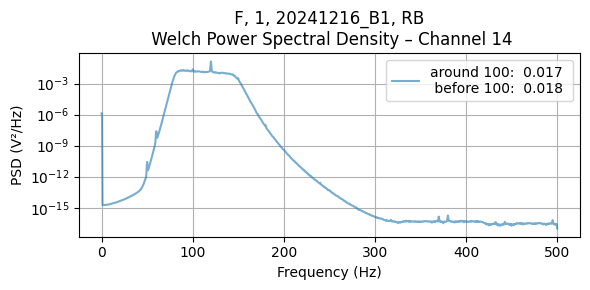

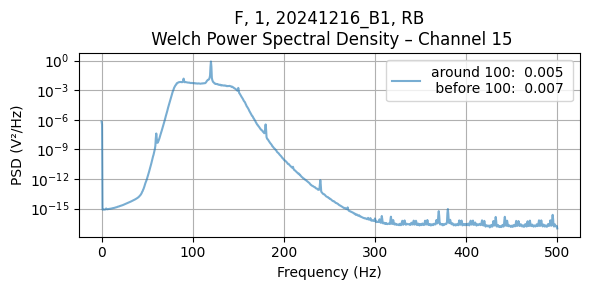

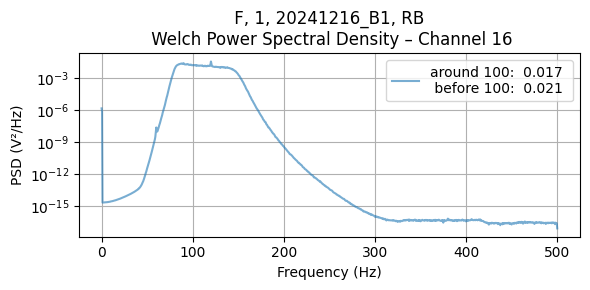

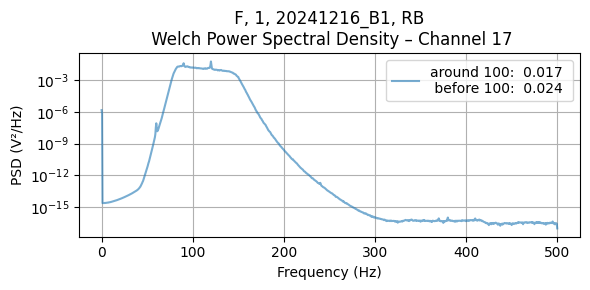

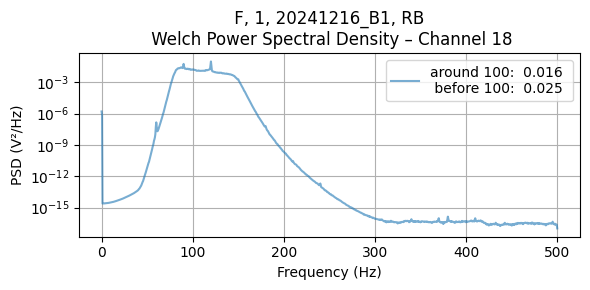

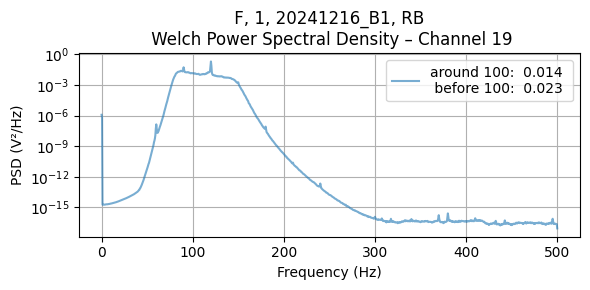

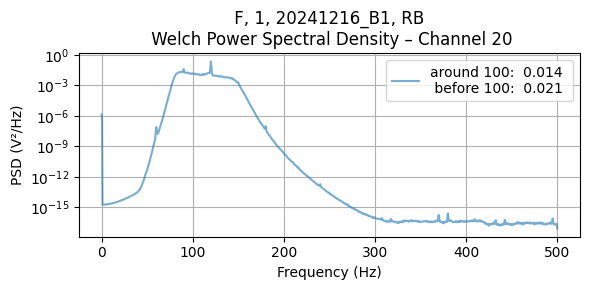

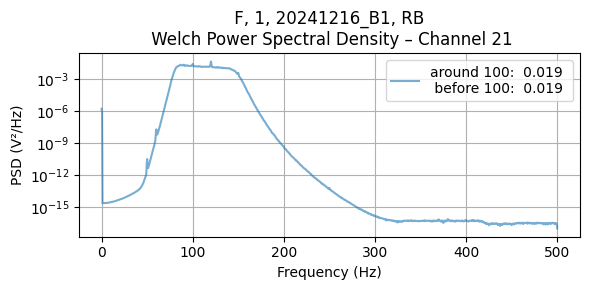

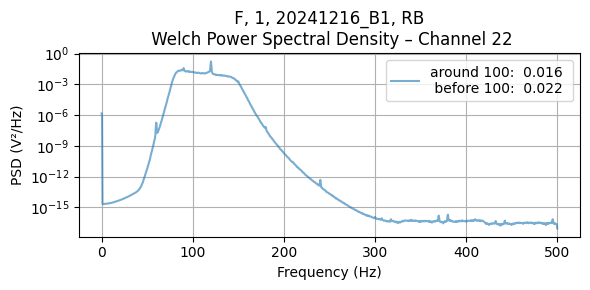

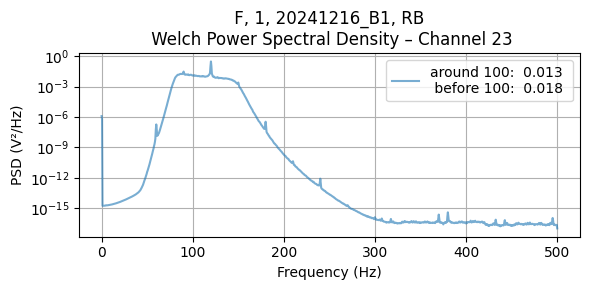

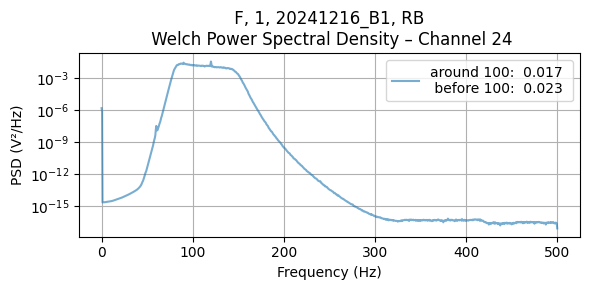

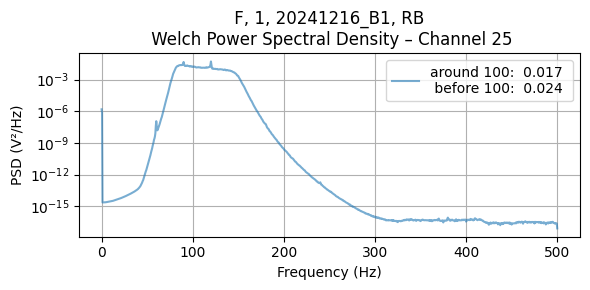

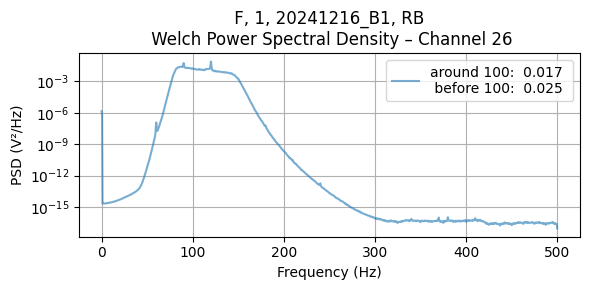

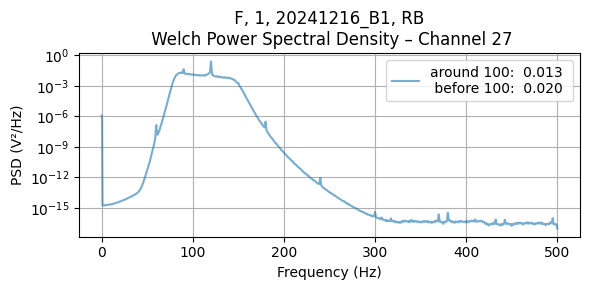

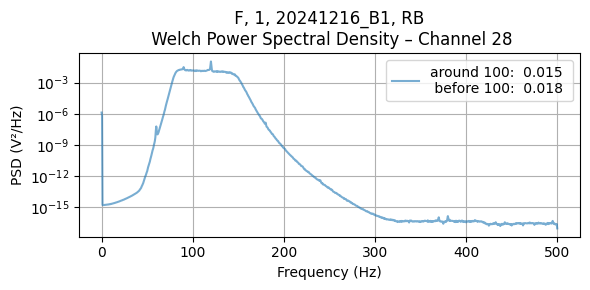

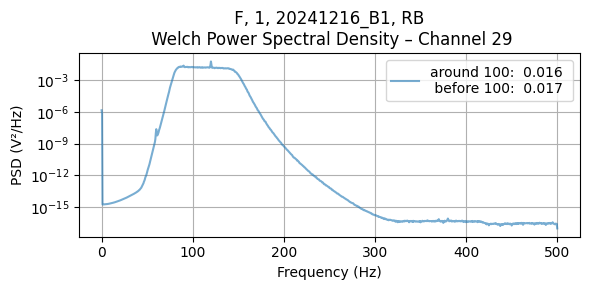

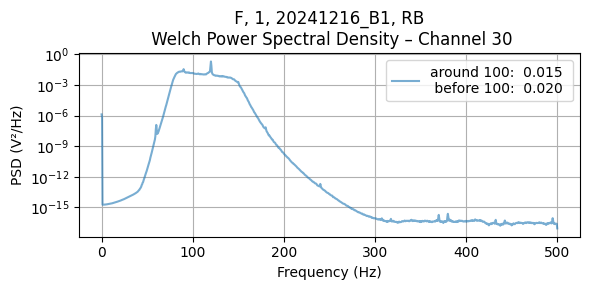

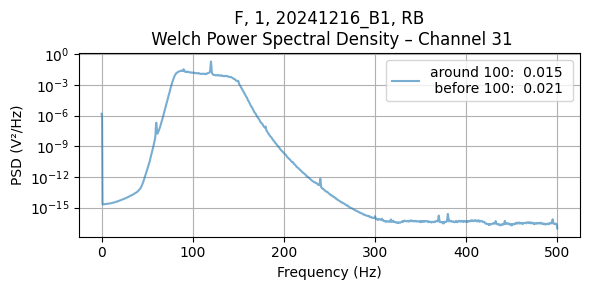

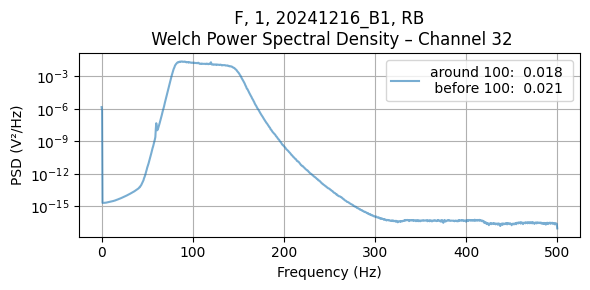

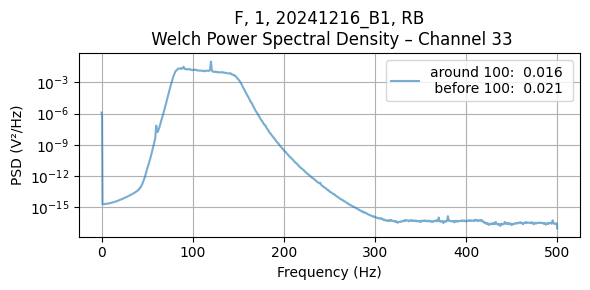

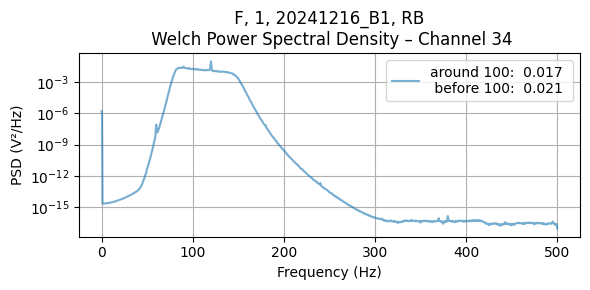

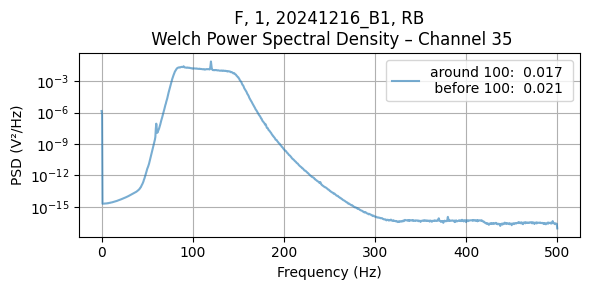

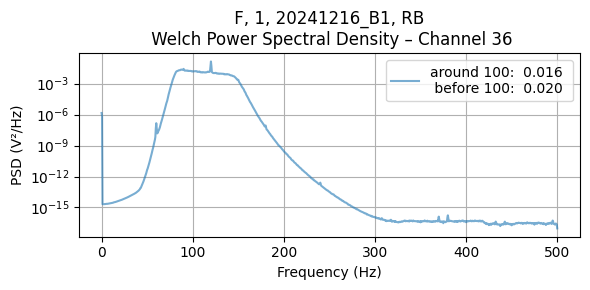

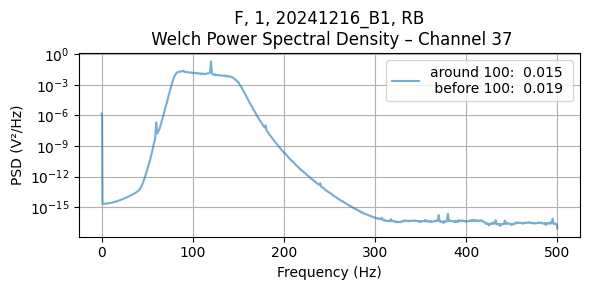

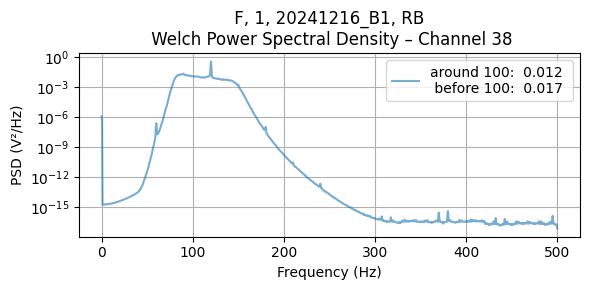

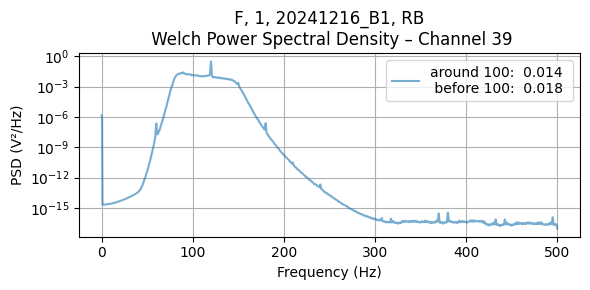

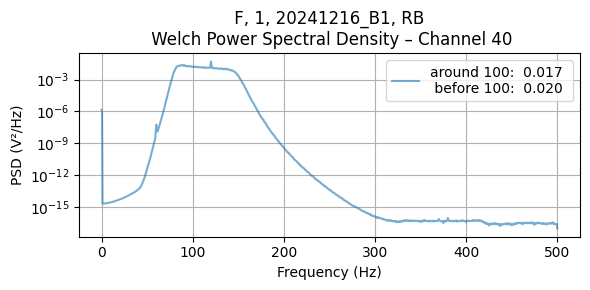

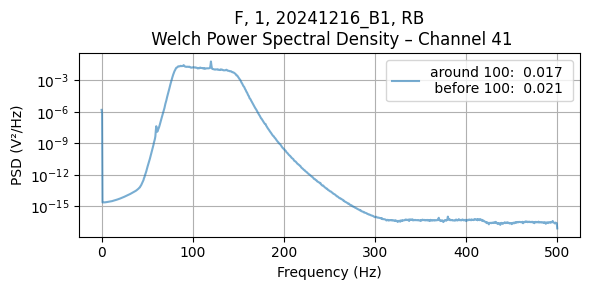

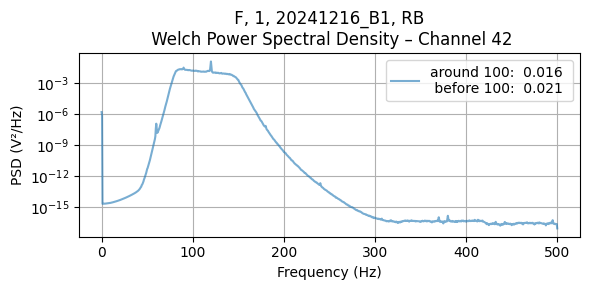

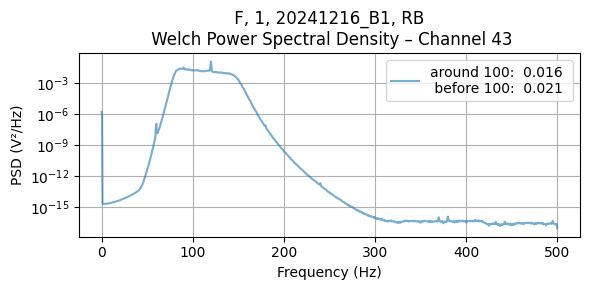

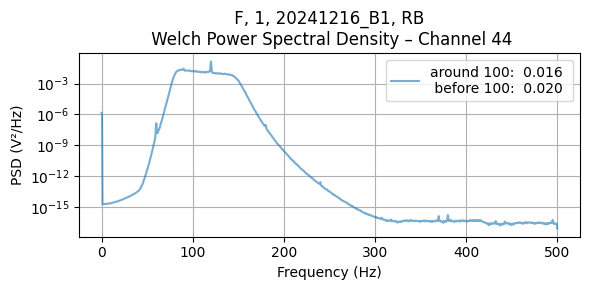

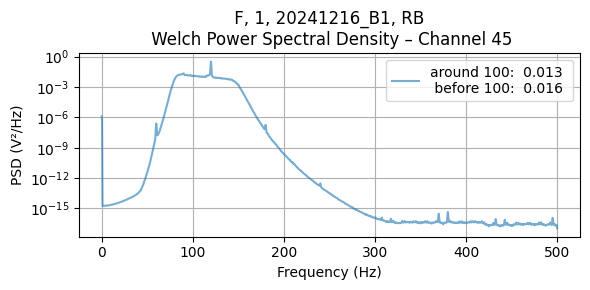

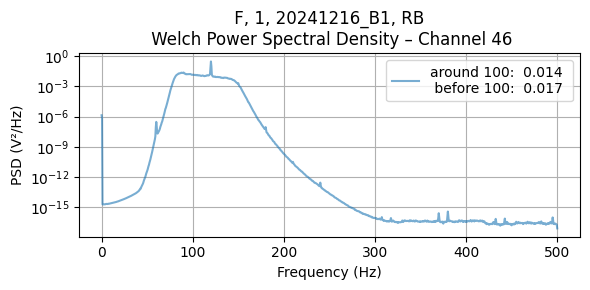

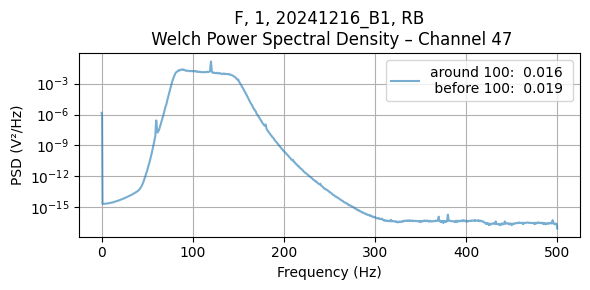

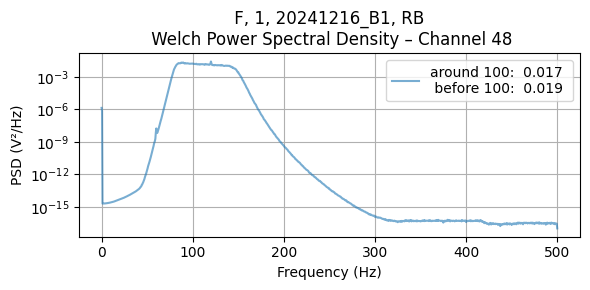

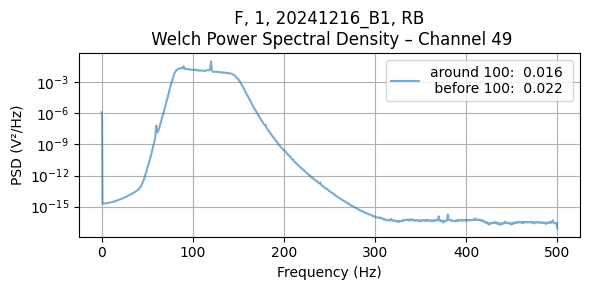

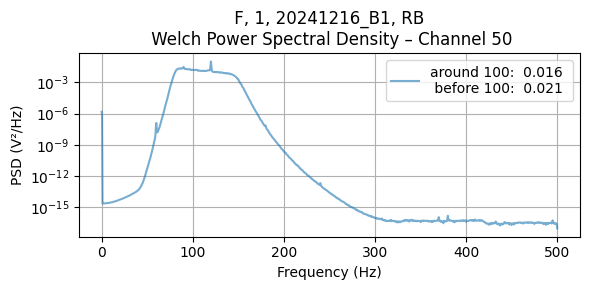

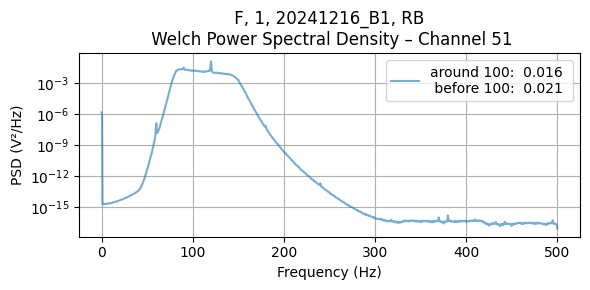

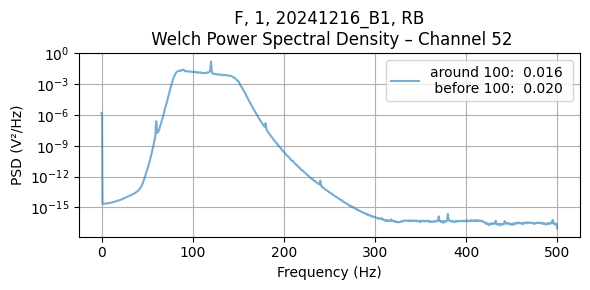

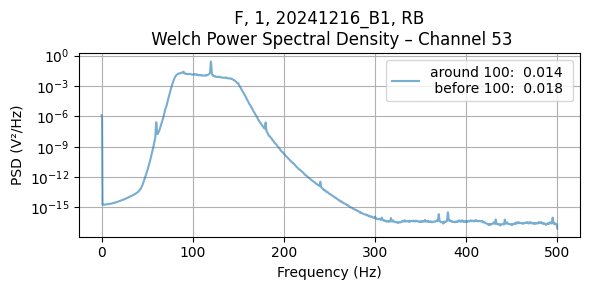

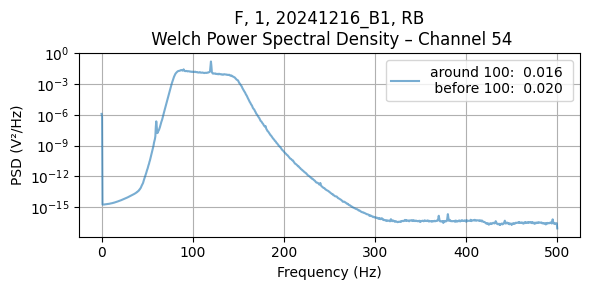

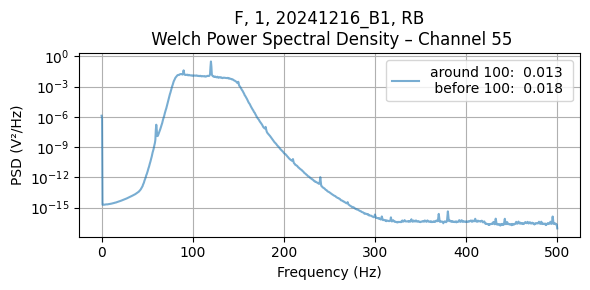

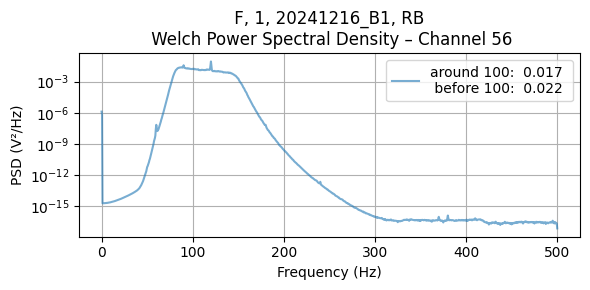

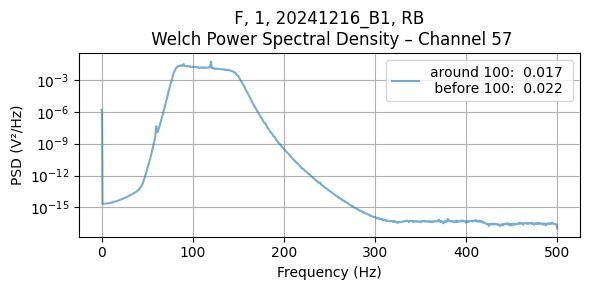

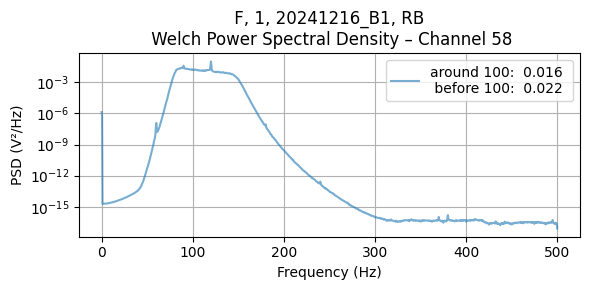

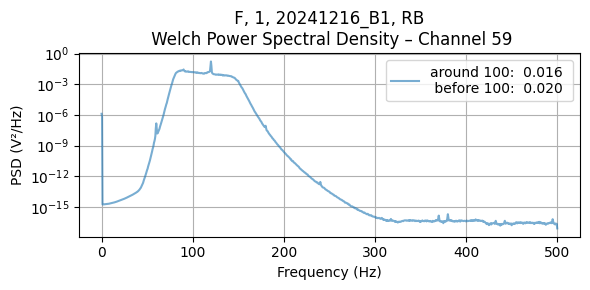

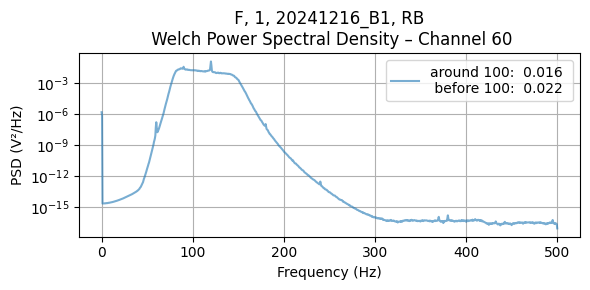

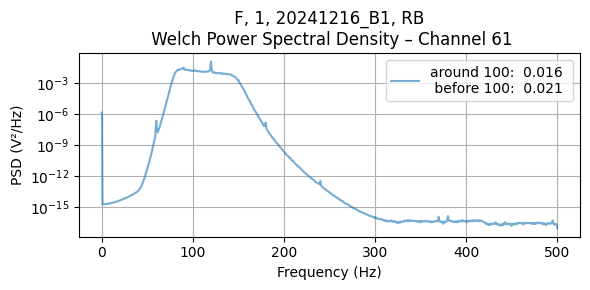

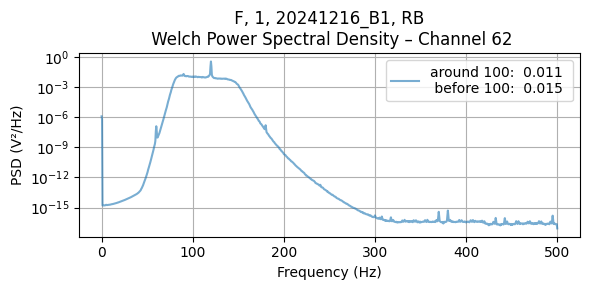

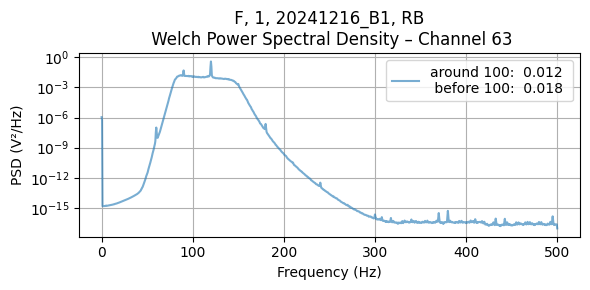

In [13]:
from scipy.signal import welch

for channel in range(64):
    # Select the data source and channel
    fs = 1000  # sampling rate in Hz (adjust to your actual rate)
    data_notch = RB_notch[channel,:]  # or RB_arr[channel]
    data = RB_arr[channel,:]
    
    # Compute Welch PSD
    frequencies, psd = welch(data, fs=fs, nperseg=fs*2)  # 2-second segments
    _, psd_notch = welch(data_notch, fs=fs, nperseg=fs*2)  # 2-second segments

    mask100 = (frequencies>=98) & (frequencies<102)
    mask_before = (frequencies>=90) & (frequencies<95)
    
    psd_around100 = np.mean(psd[mask100])
    psd_before100 = np.mean(psd[mask_before])
    
    # Plot
    plt.figure(figsize=(6, 3))
    label = f'around 100: {psd_around100: .3f} \n before 100: {psd_before100: .3f}'
    plt.semilogy(frequencies, psd, label=label, alpha=0.6)
    #plt.semilogy(frequencies,psd_notch,label='Notch',alpha=0.6)
    plt.title(f" {MONKEY}, {ARRAY}, {DATE}, RB \n Welch Power Spectral Density – Channel {channel}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (V²/Hz)")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()